In [69]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from random import random, randrange, choice, shuffle
from datetime import datetime, timedelta
from itertools import combinations
from pprint import pprint

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all" # Cell의 모든 반환값 출력

# 기본 데이터 세팅

In [70]:
블록원데이터 = pd.DataFrame({"블록명":["S1", "S2", "S3", "S4"], 
                    "중량": [50, 60, 30, 20], 
                    "가로": [10, 10, 5, 5], 
                    "세로":[10, 12, 6, 6], 
                    "표준공기":[2, 3, 1, 2], 
                    "납기":["2024-02-15", "2024-02-15", "2024-02-15", "2024-02-15"],
                    "정반배치":[0, 0, 0, 0]})
블록원데이터.head()

,블록명,중량,가로,세로,표준공기,납기,정반배치
0,S1,50,10,10,2,2024-02-15,0
1,S2,60,10,12,3,2024-02-15,0
2,S3,30,5,6,1,2024-02-15,0
3,S4,20,5,6,2,2024-02-15,0


In [71]:
정반원데이터 = pd.DataFrame({"정반명":["A", "B", "C"],
                   "가능중량":[100, 100, 30],
                   "가로":[10, 10, 5],
                   "세로":[20, 10, 10],
                   })
정반원데이터.head()

,정반명,가능중량,가로,세로
0,A,100,10,20
1,B,100,10,10
2,C,30,5,10


In [72]:
정반원데이터.index[정반원데이터["정반명"]=="B"].values[0]

1

In [73]:
start_date = datetime(2024, 2, 1)
end_date = datetime(2024, 2, 28)
날짜집합  = pd.date_range(start=start_date, end=end_date, freq='D')
날짜집합

DatetimeIndex(['2024-02-01', '2024-02-02', '2024-02-03', '2024-02-04',
               '2024-02-05', '2024-02-06', '2024-02-07', '2024-02-08',
               '2024-02-09', '2024-02-10', '2024-02-11', '2024-02-12',
               '2024-02-13', '2024-02-14', '2024-02-15', '2024-02-16',
               '2024-02-17', '2024-02-18', '2024-02-19', '2024-02-20',
               '2024-02-21', '2024-02-22', '2024-02-23', '2024-02-24',
               '2024-02-25', '2024-02-26', '2024-02-27', '2024-02-28'],
              dtype='datetime64[ns]', freq='D')

In [74]:
블록집합 = 블록원데이터["블록명"].unique().tolist()
블록집합

['S1', 'S2', 'S3', 'S4']

In [75]:
최초정반집합 = 정반원데이터["정반명"].unique().tolist()
최초정반집합

['A', 'B', 'C']

# 블록 데이터 전처리 함수

In [76]:
import functools
def unpack_df_columns(func):
    @functools.wraps(func)
    def _unpack_df_columns(*args, **kwargs):
        series = args[0]
        return func(*series.values)
    return _unpack_df_columns

In [77]:
@unpack_df_columns
def 최소착수요구일구하기(납기, 공기):
    result = pd.to_datetime(납기) - timedelta(days=int(공기))
    return result.date()

In [78]:
착수일가중치, 공기가중치, 크기가중치 = 0.7, 0.5, 0.5

@unpack_df_columns
def 블록우선순위구하기(날순, 공순, 크순):
    global 착수일가중치, 공기가중치, 크기가중치
    result = np.round((날순*착수일가중치 + 공순*공기가중치 + 크순*크기가중치)/3,1)
    return result

@unpack_df_columns
def 블록사이즈튜플만들기(가로, 세로):
    길이1 = max(가로, 세로)  
    길이2 = min(가로, 세로)
    result = (길이2, 길이1)
    return result

In [79]:
def 블록데이터전처리(블록원데이터):
    df1 = 블록원데이터.copy()
    df1["사이즈"] = df1[["가로", "세로"]].apply(블록사이즈튜플만들기, axis=1)
    df1["납기"] = pd.to_datetime(df1["납기"])
    df1["면적"] = df1.eval("가로*세로")
    df1["최소착수요구일"] = df1[["납기", "표준공기"]].apply(최소착수요구일구하기, axis=1)
    df1["날짜순서"] = df1["최소착수요구일"].rank()
    df1["공기순서"] = df1["표준공기"].rank(ascending=False)
    df1["크기순서"] = df1["면적"].rank(ascending=False)
    df1["우선순위"] = df1[["날짜순서", "공기순서", "크기순서"]].apply(블록우선순위구하기, axis=1)
    
    df1 = df1.drop(['가로', '세로'], axis=1)
    df1 = df1.sort_values(by=["우선순위"])
    return df1

In [80]:
df1 = 블록데이터전처리(블록원데이터)
df1

,블록명,중량,표준공기,납기,정반배치,사이즈,면적,최소착수요구일,날짜순서,공기순서,크기순서,우선순위
1,S2,60,3,2024-02-15,0,"(10, 12)",120,2024-02-12,1.0,1.0,1.0,0.6
0,S1,50,2,2024-02-15,0,"(10, 10)",100,2024-02-13,2.5,2.5,2.0,1.3
3,S4,20,2,2024-02-15,0,"(5, 6)",30,2024-02-13,2.5,2.5,3.5,1.6
2,S3,30,1,2024-02-15,0,"(5, 6)",30,2024-02-14,4.0,4.0,3.5,2.2


In [81]:
공기가중치 = [9, 0.5]
크기가중치 = [0.5, 9]
착수일가중치 = 0.5
for 공기가중치, 크기가중치 in zip(공기가중치, 크기가중치):
    df2 = 블록데이터전처리(블록원데이터)
    print(df2[["블록명", "우선순위"]])

  블록명  우선순위
1  S2   3.3
0  S1   8.2
3  S4   8.5
2  S3  13.2
  블록명  우선순위
1  S2   3.3
0  S1   6.8
3  S4  11.3
2  S3  11.8


# 정반 데이터 전처리 함수

In [82]:
중량가중치, 크기가중치 = 0.5, 0.7

@unpack_df_columns
def 정반우선순위구하기(중순, 크순):
    global 중량가중치, 크기가중치
    result = np.round((중순*중량가중치 + 크순*크기가중치)/3,1)
    return result

@unpack_df_columns
def 정반사이즈튜플만들기(가로, 세로):
    길이1 = max(가로, 세로)  
    길이2 = min(가로, 세로)
    result = (길이1, 길이2)
    return result

In [83]:
def 정반데이터전처리(정반원데이터):
    df = 정반원데이터.copy()
    
    df["사이즈"] = df[["가로", "세로"]].apply(정반사이즈튜플만들기, axis=1)
    df["면적"] = df.eval("가로*세로")
    df["중량순서"] = df["가능중량"].rank(ascending=False)
    df["크기순서"] = df["면적"].rank(ascending=False)
    df["우선순위"] = df[["중량순서", "크기순서"]].apply(정반우선순위구하기, axis=1)
    
    df = df.drop(['가로', '세로'], axis=1)
    df = df.sort_values(by=["우선순위"])
    return df

In [84]:
df2 = 정반데이터전처리(정반원데이터)
df2

,정반명,가능중량,사이즈,면적,중량순서,크기순서,우선순위
0,A,100,"(20, 10)",200,1.5,1.0,0.5
1,B,100,"(10, 10)",100,1.5,2.0,0.7
2,C,30,"(10, 5)",50,3.0,3.0,1.2


In [85]:
중량가중치들 = [0.9, 0.01]
크기가중치들 = [0.01, 3]

for 중량가중치, 크기가중치 in zip(중량가중치들, 크기가중치들):
    df2 = 정반데이터전처리(정반원데이터)
    print(df2[["정반명", "우선순위"]])

  정반명  우선순위
0   A   0.5
1   B   0.5
2   C   0.9
  정반명  우선순위
0   A   1.0
1   B   2.0
2   C   3.0


# 변수정리함수

In [86]:
def 블록변수정리(블록데이터, target_block):
    블록 = dict()
    블록["블록명"] = target_block
    블록["인덱스"] =  블록데이터[블록데이터["블록명"]==target_block].index.values[0]
    블록["중량"] = 블록데이터[블록데이터["블록명"]==target_block]["중량"].values[0]
    블록["사이즈"] = 블록데이터[블록데이터["블록명"]==target_block]["사이즈"].values[0]
    블록["면적"] = 블록데이터[블록데이터["블록명"]==target_block]["면적"].values[0]
    블록["표준공기"] = 블록데이터[블록데이터["블록명"]==target_block]["표준공기"].values[0]
    블록["최소착수요구일"] = 블록데이터[블록데이터["블록명"]==target_block]["최소착수요구일"].values[0]
    return 블록

In [87]:
블록변수정리(df1, "S1")

{'블록명': 'S1',
 '인덱스': 0,
 '중량': 50,
 '사이즈': (10, 10),
 '면적': 100,
 '표준공기': 2,
 '최소착수요구일': datetime.date(2024, 2, 13)}

In [88]:
def 정반변수정리(정반데이터, 정반명):
    정반 = dict()
    정반["정반명"] = 정반명
    정반["가능중량"] = 정반데이터[정반데이터["정반명"]==정반명]["가능중량"].values[0]
    정반["사이즈"] = 정반데이터[정반데이터["정반명"]==정반명]["사이즈"].values[0]
    정반["면적"] = 정반데이터[정반데이터["정반명"]==정반명]["면적"].values[0]
    
    return 정반

In [89]:
A = 정반변수정리(df2, "A")
A

{'정반명': 'A', '가능중량': 100, '사이즈': (20, 10), '면적': 200}

# 정반가능중량 조건 적합도 검토

In [90]:
def 정반가능중량검토(target_block, 블록데이터, 정반, 정반데이터):
    블록중량 = 블록데이터[블록데이터["블록명"]==target_block]["중량"].values[0]
    정반가능중량 = 정반데이터[정반데이터["정반명"]==정반]["가능중량"].values[0]
    
    if 정반가능중량 > 블록중량: 
        return "적합"
    else:
        return "부적합"

In [91]:
정반가능중량검토("S1", df1, "A", df2)

'적합'

# 면적 달력 함수 정의

In [92]:
def create_면적달력(시작년:int, 시작월:int, 종료년:int, 종료월:int, 정반데이터):
    start_date = datetime(시작년, 시작월, 1)
    end_date = datetime(종료년, 종료월, 28)
    정반집합 = 정반데이터["정반명"].tolist()
    날짜집합  = pd.date_range(start=start_date, end=end_date, freq='D')
    
    배치달력 = pd.DataFrame()
    배치달력.index = 날짜집합
   
    for 정반 in 정반집합:
        배치달력[f"{정반}"] = 정반데이터[정반데이터["정반명"]==정반]["면적"].values[0]

    return 배치달력

In [93]:
면적달력 = create_면적달력(2024, 2, 2024, 2, df2)
면적달력.head(3)

,A,B,C
2024-02-01,200,100,50
2024-02-02,200,100,50
2024-02-03,200,100,50


In [94]:
def get_최선조기착수일후보(면적달력, 정반리스트, 대상블록, 블록데이터):
    result_dict = dict()
    
    블록면적 = 블록데이터[블록데이터["블록명"]==대상블록]["면적"].values[0]
    표준공기 = 블록데이터[블록데이터["블록명"]==대상블록]["표준공기"].values[0]
    print(f"블록명:{대상블록}, 블록면적:{블록면적}, 표준공기:{표준공기}")
    
    for 대상정반 in 정반리스트:
        
        대상정반면적리스트 = 면적달력[f"{대상정반}"].iloc[:].values
#         print(f"{대상정반면적리스트}")    
        
        for i in range(len(대상정반면적리스트)):
            조회시점인덱스 = i
            조회구간면적리스트 = 대상정반면적리스트[조회시점인덱스:조회시점인덱스+표준공기]
            조회기간최소면적 = min(조회구간면적리스트)
#             print(f"조회시점인덱스:{조회시점인덱스}, 조회기간최소면적:{조회기간최소면적}")
            
            if 조회기간최소면적 >= 블록면적:
                최선조기착수일 = 면적달력.index[조회시점인덱스]
                result_dict[대상정반] = 최선조기착수일
                print(f"대상정반:{대상정반}, 최선조기착수일: {최선조기착수일}")  
                break
        
    return result_dict

In [95]:
정반리스트 = ["A", "B"]
최선조기착수일후보 = get_최선조기착수일후보(면적달력, 정반리스트, "S2", df1)
최선조기착수일후보

블록명:S2, 블록면적:120, 표준공기:3
대상정반:A, 최선조기착수일: 2024-02-01 00:00:00


{'A': Timestamp('2024-02-01 00:00:00', freq='D')}

In [96]:
def get_최선조기착수대상(최선조기착수일후보):
    # 복수의 경우 셔플후 랜덤 선택
    temp_list = list(최선조기착수일후보.items())
    shuffle(temp_list)
    최선조기착수일후보 = dict(temp_list)

    earliest_item = min(최선조기착수일후보.items(), key=lambda x: x[1])
    최선정반 = earliest_item[0]
    최선착수일 = earliest_item[1].strftime('%Y-%m-%d')
    return 최선정반, 최선착수일

In [97]:
최선조기착수대상 = get_최선조기착수대상(최선조기착수일후보)
최선조기착수대상

('A', '2024-02-01')

In [98]:
def update_면적달력(면적달력, 최선조기착수대상, 배치블록명, 블록데이터):
    
    정반리스트 = 면적달력.columns.tolist()
    블록면적 = 블록데이터[블록데이터["블록명"]==배치블록명]["면적"].values[0]
    표준공기 = 블록데이터[블록데이터["블록명"]==배치블록명]["표준공기"].values[0]
    블록착수일 = 최선조기착수대상[1]
    시점인덱스 = list(면적달력.index.strftime('%Y-%m-%d')).index(블록착수일)
    정반 = 최선조기착수대상[0]
        

    조회기간면적리스트 = 면적달력[f"{정반}"].iloc[시점인덱스:시점인덱스+표준공기].values

    if min(조회기간면적리스트) >= 블록면적:
        for idx, 대상일면적 in enumerate(조회기간면적리스트):
            수정면적 = 대상일면적 - 블록면적
            대상일인덱스 = 시점인덱스 + idx
            면적달력[f"{정반}"].iloc[대상일인덱스:대상일인덱스+1] = 수정면적
#             print(f"정반면적:{대상일면적}, 수정면적:{수정면적}")
    else:
        print("면적이 부족하여 블록을 배치할 수 없습니다.")
    
    return 면적달력
    

In [99]:
면적달력 = update_면적달력(면적달력, 최선조기착수대상, "S4", df1)
면적달력.head(10)

,A,B,C
2024-02-01,170,100,50
2024-02-02,170,100,50
2024-02-03,200,100,50
2024-02-04,200,100,50
2024-02-05,200,100,50
2024-02-06,200,100,50
2024-02-07,200,100,50
2024-02-08,200,100,50
2024-02-09,200,100,50
2024-02-10,200,100,50


# 정반면적 조건 적합도 검토

## 함수 정의

In [100]:
def 정반세팅(사이즈):  #사이즈 = (10, 10)
    surface_width, surface_height = 사이즈[0], 사이즈[1]  # Adjusted to match the provided image for demonstration
    surface = np.zeros((surface_height, surface_width), dtype=int)
    return surface, surface_width, surface_height

In [101]:
# Function to check if a block can be placed on the surface
def can_place(surface, surface_width, surface_height, block, start_row, start_col):
    block_height, block_width = block
    if start_row + block_height > surface_height or start_col + block_width > surface_width:
        return False
    return np.all(surface[start_row:start_row + block_height, start_col:start_col + block_width] == 0)

# Function to place a block on the surface, if possible
def place_block(surface, block, start_row, start_col, block_id):
    block_height, block_width = block
    surface[start_row:start_row + block_height, start_col:start_col + block_width] = block_id

# Function to find the best fit for a block on the surface
def find_best_fit(surface, surface_width, surface_height, block, block_id):
    best_fit_score = float('inf')
    best_position = None
    block_height, block_width = block

    # Iterate over all possible positions on the surface
    for y in range(surface_height - block_height + 1):
        for x in range(surface_width - block_width + 1):
            if can_place(surface, surface_width, surface_height, block, y, x):
                # Calculate a score; here we use the top-left corner (y, x) as the score
                # A lower score means the block is closer to the top-left
                score = y + x
                if score < best_fit_score:
                    best_fit_score = score
                    best_position = (y, x)

    # If a best position was found, place the block there
    if best_position:
        place_block(surface, block, *best_position, block_id)
        return True
    return False  # No fit found

# Function to fit blocks on the surface in order
def fit_blocks(surface, surface_width, surface_height, blocks, names):
    result = ""
    block_id = max(map(max, surface))+1  # Start numbering blocks from 1
    for name, block in zip(names, blocks):
        if not find_best_fit(surface, surface_width, surface_height, block, block_id):
            print(f"Block {block_id} of size {block} could not be placed.")
            result = "부적합"
        else:
            result = "적합"
        block_id += 1  # Increment block_id for the next block
    return surface, result

In [102]:
def draw1(surface, block_names):
    fig, ax = plt.subplots(figsize=(5, 5))

    cmap = mcolors.ListedColormap(['white'] + ['C{}'.format(i) for i in range(len(block_names))])
    norm = mcolors.BoundaryNorm(np.arange(0.5, len(block_names) + 2), cmap.N)

    ax.imshow(surface, cmap=cmap, norm=norm)

    for y in range(surface.shape[0]):
        for x in range(surface.shape[1]):
            if surface[y, x] != 0:
                ax.text(x, y, str(block_names[surface[y, x]-1]), ha='center', va='center', color='black')
                
    ax.set_xticks(np.arange(-.5, surface.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-.5, surface.shape[0], 1), minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=1)
    ax.tick_params(which="minor", size=0)

    ax.set_xticks([])
    ax.set_yticks([])

    plt.show()

## 단순시뮬

In [103]:
사이즈 = (10, 10)
surface, surface_width, surface_height = 정반세팅(사이즈)
surface, surface_width, surface_height

(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 10,
 10)

In [104]:
# Define the blocks we want to place with a unique ID for each block type
block_sizes = [(2, 2), (3, 3), (2, 4), (4, 5), (2, 4), (2, 6), (2, 5), (4, 6), (2, 8), (4, 5)]  # Updated block list
block_names = ["S1", "S2", "S3", "S4", "S5", "S6", "S7", "S8","S9", "S10"]

In [105]:
# Place the blocks on the surface
results = fit_blocks(surface, surface_width, surface_height, block_sizes, block_names)
surface = results[0]
적합도 = results[1]

Block 8 of size (4, 6) could not be placed.
Block 9 of size (2, 8) could not be placed.
Block 10 of size (4, 5) could not be placed.


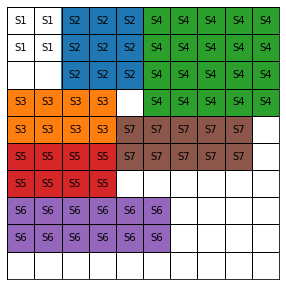

In [106]:
draw1(surface, block_names)

## 정반 한개에만 배치 시뮬

In [107]:
정반사이즈 = (10, 5)
surface, surface_width, surface_height = 정반세팅(정반사이즈)
surface, surface_width, surface_height

(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 10,
 5)

In [108]:
block_sizes = []
block_names = []

In [109]:
블록사이즈 = (3, 10)
블록명 = "A"
block_size = [블록사이즈]
block_name = [블록명]
block_size, block_name

([(3, 10)], ['A'])

In [110]:
result = fit_blocks(surface, surface_width, surface_height, block_size, block_name)
적합도 = result[1]
적합도

'적합'

In [111]:
block_sizes.append(블록사이즈)
block_names.append(블록명)
surface, surface_width, surface_height = 정반세팅(사이즈)

In [112]:
# Place the blocks on the surface
results = fit_blocks(surface, surface_width, surface_height, block_sizes, block_names)
surface = results[0]
surface

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

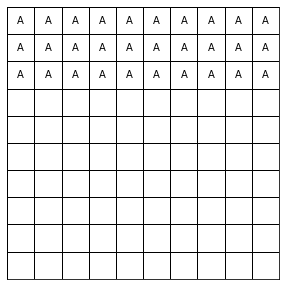

In [113]:
draw1(surface, block_names)

In [114]:
block_size = [(2, 4)]
block_name = ["B"]
block_size, block_name

([(2, 4)], ['B'])

In [115]:
result = fit_blocks(surface, surface_width, surface_height, block_size, block_name)
적합도 = result[1]
적합도

'적합'

In [116]:
block_sizes = block_sizes + block_size
block_names = block_names + block_name
block_sizes, block_names

surface, surface_width, surface_height = 정반세팅(사이즈)

([(3, 10), (2, 4)], ['A', 'B'])

In [117]:
# Place the blocks on the surface
results = fit_blocks(surface, surface_width, surface_height, block_sizes, block_names)
surface = results[0]
적합도 = results[1]
surface
적합도

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [2, 2, 2, 2, 0, 0, 0, 0, 0, 0],
       [2, 2, 2, 2, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

'적합'

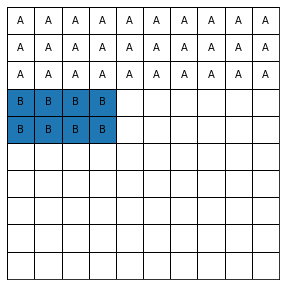

In [118]:
draw1(surface, block_names)

## 복수정반 배치 시뮬

In [119]:
def 정반배치적합도체크(정반명, 정반데이터, 추가블록명, 블록데이터):
    global fin_results 
    
  
    정반사이즈 = 정반데이터[정반데이터["정반명"]==정반명]["사이즈"].values[0]
    블록사이즈 = 블록데이터[블록데이터["블록명"]==추가블록명]["사이즈"].values[0]
    
    fin_results[정반명]["block_sizes"] = fin_results[정반명]["block_sizes"] + [블록사이즈]
    fin_results[정반명]["block_names"] = fin_results[정반명]["block_names"] + [추가블록명]
    
    surface, surface_width, surface_height = 정반세팅(정반사이즈)
    배치결과 = fit_blocks(surface, surface_width, surface_height, fin_results[정반명]["block_sizes"], fin_results[정반명]["block_names"])
#     print(f"배치결과: {배치결과[1]}")
    
    if 배치결과[1] == "적합":
        배치레이아웃 = 배치결과[0]
        draw1(배치레이아웃, fin_results[정반명]["block_names"])
        
    else:
        fin_results[정반명]["block_sizes"].remove(블록사이즈)
        fin_results[정반명]["block_names"].remove(추가블록명)
    
    return 배치결과[1], fin_results

In [120]:
fin_results = {
    "A": {"block_sizes":[], "block_names":[]},
    "B": {"block_sizes":[], "block_names":[]},
          }

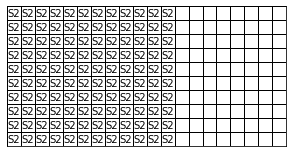

('적합',
 {'A': {'block_sizes': [(10, 12)], 'block_names': ['S2']},
  'B': {'block_sizes': [], 'block_names': []}})

In [121]:
정반배치적합도체크("A", df2, "S2", df1)

In [122]:
정반배치적합도체크("A", df2, "S2", df1)

Block 2 of size (10, 12) could not be placed.


('부적합',
 {'A': {'block_sizes': [(10, 12)], 'block_names': ['S2']},
  'B': {'block_sizes': [], 'block_names': []}})

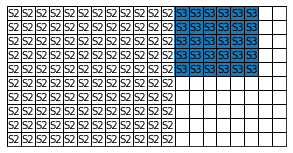

('적합',
 {'A': {'block_sizes': [(10, 12), (5, 6)], 'block_names': ['S2', 'S3']},
  'B': {'block_sizes': [], 'block_names': []}})

In [123]:
정반배치적합도체크("A", df2, "S3", df1)

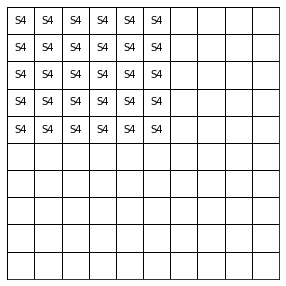

('적합',
 {'A': {'block_sizes': [(10, 12), (5, 6)], 'block_names': ['S2', 'S3']},
  'B': {'block_sizes': [(5, 6)], 'block_names': ['S4']}})

In [124]:
정반배치적합도체크("B", df2, "S4", df1)

# 생산계획수립

In [157]:
def 생산계획수립(블록데이터, 정반데이터, 시작년월, 종료년월):
    
    블록리스트 = 블록데이터["블록명"].tolist()
    정반리스트 = 정반데이터["정반명"].tolist()
    시작년도 = 시작년월[:4]
    시작월 = 시작년월[5:7]
    종료년도 = 종료년월[:4]
    종료월 = 종료년월[5:7]
    면적달력 = create_면적달력(2024, 2, 2024, 2, df2)
    
    결론_블록리스트 = []
    결론_정반리스트 = []
    결론_착수일자 = []
    
        
    for _ in tqdm(range(len(블록리스트))):
        
        if 블록리스트:
            target_block = 블록리스트[0]
        else:
            print("수정블록리스트에 검토대상 잔여블록이 없습니다.")
            print()
            break        
        
        블록 = 블록변수정리(블록데이터, target_block)
        블록명 = 블록["블록명"]
        print(f"검토대상블록: {블록명}")
        
        ## 정반가능중량 조건 적합도 검토 ----------------------------------------------------------
        result1 = []
        for 정반 in 정반리스트:
            중량적합도 = 정반가능중량검토(target_block, 블록데이터, 정반, 정반데이터)
            if 중량적합도 == "적합":
                result1.append(정반)
        
        print(f"중량조건적합정반들: {result1}")
        
        ## 최선조기착수일 검토 ---------------------------------------------------------------------
        최선조기착수일후보 = get_최선조기착수일후보(면적달력, result1, target_block, 블록데이터)
        print(f"최선조기착수일후보: {최선조기착수일후보}")
        
        최선조기착수대상 = get_최선조기착수대상(최선조기착수일후보)
        최선정반명 = 최선조기착수대상[0]
        최선조기착수일 = 최선조기착수대상[1]
        
        print(f"최선정반명:{최선정반명}, 최선조기착수일:{최선조기착수일}")
        print()
        
        ## 정반배치레이아웃검토---------------------------------------------------------------------------------        
        정반배치적합도 = 정반배치적합도체크(최선정반명, 정반데이터, target_block, 블록데이터)
        print(정반배치적합도[0])
        
        if 정반배치적합도[0] == "적합":
            결론_블록리스트.append(target_block)
            결론_정반리스트.append(최선정반명)
            결론_착수일자.append(최선조기착수일)
            면적달력 = update_면적달력(면적달력, 최선조기착수대상, target_block, 블록데이터)
            
        else:
            print("배치가능한 정반이 없습니다.")
        
        블록리스트.remove(target_block)
        print(f"검토후 블록리스트 : {블록리스트}")

        print("="*70)
        
        
    return 정반배치적합도, 결론_블록리스트, 결론_정반리스트, 결론_착수일자, 면적달력

In [158]:
data_num = 1

블록원데이터 = pd.read_excel(f"./data/data{data_num}.xlsx", sheet_name="블록데이터")
정반원데이터 = pd.read_excel(f"./data/data{data_num}.xlsx", sheet_name="정반데이터")

블록데이터 = 블록데이터전처리(블록원데이터)
정반데이터 = 정반데이터전처리(정반원데이터)


  0%|                                                                          | 0/4 [00:00<?, ?it/s]

검토대상블록: S2
중량조건적합정반들: ['A', 'B']
블록명:S2, 블록면적:120, 표준공기:5
대상정반:A, 최선조기착수일: 2024-02-01 00:00:00
최선조기착수일후보: {'A': Timestamp('2024-02-01 00:00:00', freq='D')}
최선정반명:A, 최선조기착수일:2024-02-01



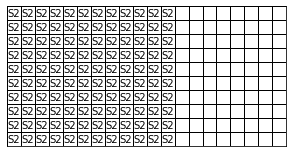

 25%|████████████████▌                                                 | 1/4 [00:00<00:01,  1.84it/s]

적합
검토후 블록리스트 : ['S1', 'S4', 'S3']
검토대상블록: S1
중량조건적합정반들: ['A', 'B']
블록명:S1, 블록면적:100, 표준공기:8
대상정반:A, 최선조기착수일: 2024-02-06 00:00:00
대상정반:B, 최선조기착수일: 2024-02-01 00:00:00
최선조기착수일후보: {'A': Timestamp('2024-02-06 00:00:00', freq='D'), 'B': Timestamp('2024-02-01 00:00:00', freq='D')}
최선정반명:B, 최선조기착수일:2024-02-01



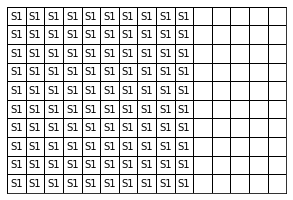

 50%|█████████████████████████████████                                 | 2/4 [00:00<00:00,  2.69it/s]

적합
검토후 블록리스트 : ['S4', 'S3']
검토대상블록: S4
중량조건적합정반들: ['A', 'B', 'C']
블록명:S4, 블록면적:30, 표준공기:6
대상정반:A, 최선조기착수일: 2024-02-01 00:00:00
대상정반:B, 최선조기착수일: 2024-02-09 00:00:00
대상정반:C, 최선조기착수일: 2024-02-01 00:00:00
최선조기착수일후보: {'A': Timestamp('2024-02-01 00:00:00', freq='D'), 'B': Timestamp('2024-02-09 00:00:00', freq='D'), 'C': Timestamp('2024-02-01 00:00:00', freq='D')}
최선정반명:C, 최선조기착수일:2024-02-01



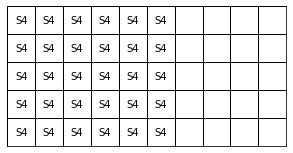

 75%|█████████████████████████████████████████████████▌                | 3/4 [00:00<00:00,  3.79it/s]

적합
검토후 블록리스트 : ['S3']
검토대상블록: S3
중량조건적합정반들: ['A', 'B']
블록명:S3, 블록면적:30, 표준공기:5
대상정반:A, 최선조기착수일: 2024-02-01 00:00:00
대상정반:B, 최선조기착수일: 2024-02-09 00:00:00
최선조기착수일후보: {'A': Timestamp('2024-02-01 00:00:00', freq='D'), 'B': Timestamp('2024-02-09 00:00:00', freq='D')}
최선정반명:A, 최선조기착수일:2024-02-01



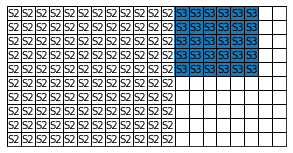

100%|██████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.84it/s]

적합
검토후 블록리스트 : []


(('적합',
  {'A': {'block_sizes': [(10, 12), (5, 6)],
    'block_names': ['S2', 'S3'],
    'best_st_date': []},
   'B': {'block_sizes': [(10, 10)], 'block_names': ['S1'], 'best_st_date': []},
   'C': {'block_sizes': [(5, 6)], 'block_names': ['S4'], 'best_st_date': []}}),
 ['S2', 'S1', 'S4', 'S3'],
 ['A', 'B', 'C', 'A'],
 ['2024-02-01', '2024-02-01', '2024-02-01', '2024-02-01'],
               A    B   C
 2024-02-01   50    0  20
 2024-02-02   50    0  20
 2024-02-03   50    0  20
 2024-02-04   50    0  20
 2024-02-05   50    0  20
 2024-02-06  200    0  20
 2024-02-07  200    0  50
 2024-02-08  200    0  50
 2024-02-09  200  100  50
 2024-02-10  200  100  50
 2024-02-11  200  100  50
 2024-02-12  200  100  50
 2024-02-13  200  100  50
 2024-02-14  200  100  50
 2024-02-15  200  100  50
 2024-02-16  200  100  50
 2024-02-17  200  100  50
 2024-02-18  200  100  50
 2024-02-19  200  100  50
 2024-02-20  200  100  50
 2024-02-21  200  100  50
 2024-02-22  200  100  50
 2024-02-23  200  100  

In [159]:
fin_results = {
"A": {"block_sizes":[], "block_names":[], "best_st_date":[]},
"B": {"block_sizes":[], "block_names":[], "best_st_date":[]},
"C": {"block_sizes":[], "block_names":[], "best_st_date":[]},
      }

생산계획수립(블록데이터, 정반데이터, "2024-02", "2024-02")

In [128]:
import plotly.express as px
def draw_gant(df):
    fig = px.timeline(
        
        df, 
        x_start="착수일", 
        x_end="종료일", 
        y="정반명",
        color="정반구분",
        hover_data = ["표준공기", "조립중량"],
        text = "차트텍스트",
        opacity=0.7
        )

    fig.update_yaxes(autorange="reversed")          #if not specified as 'reversed', the tasks will be listed from bottom up       
    fig.update_layout(
                    # title='Project Plan Gantt Chart',
                    hoverlabel_bgcolor='#DAEEED',   #Change the hover tooltip background color to a universal light blue color. If not specified, the background color will vary by team or completion pct, depending on what view the user chooses
                    bargap=0.2,
                    height=500,              
                    xaxis_title="", 
                    yaxis_title="정반명", 
                    font=dict(
                        family="Courier New, monospace",
                        size=12,  # Set the font size here
                        color="RebeccaPurple"
                        ),
    )
    fig.show()